In [83]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import json
from scipy.sparse import csr_matrix, save_npz, load_npz

# Import user-defined libraries:
sys.path.append(os.path.abspath('/Users/martina/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Git/rom-cylinder_DEIM-POD/offline-online stages/fit White/0. full order'))
from FreeFEM import FFmatrix_fread, FFvector_fread

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_1621/672054563.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_1621/672054563.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


In [113]:
#Va fatto una volta sola e poi vale per sempre
xz_y_0 = FFvector_fread('../mesh_utilities/xz_y_0.btxt')
save_npz('../mesh_utilities/xz_y_0.npz', csr_matrix(xz_y_0))
xy_z = FFvector_fread('../mesh_utilities/xy_z.btxt')
save_npz('../mesh_utilities/xy_z.npz', csr_matrix(xy_z))

In [114]:
# Load
coordinates_Px = FFvector_fread('../mesh_utilities/vv_cc_Px.btxt')
coordinates_Pq = FFvector_fread('../mesh_utilities/vv_cc_Pq.btxt')
sol_new_C = np.loadtxt('../data/Concentration_field.csv', delimiter=',')
OpenFOAM=np.loadtxt("../data/volFieldValue.dat")    
df = pd.read_csv('../data/Solution.csv')

xz_y_0 = load_npz('../mesh_utilities/xz_y_0.npz')
xy_z = load_npz('../mesh_utilities/xy_z.npz')

OpenFOAM average concentration (@ final time): 4.50696e+24 atm/m^3
Python average concentration (@ final time): 4.510621327059395e+24 atm/m^3
Relative error (@ final time): 0.08124%


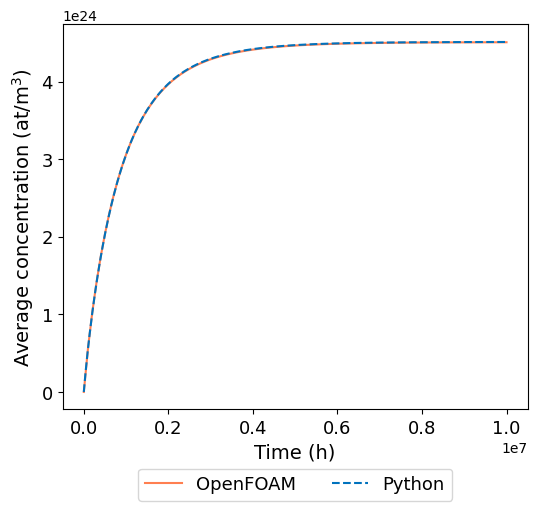

In [111]:
print('OpenFOAM average concentration (@ final time):', OpenFOAM[-1,1], 'atm/m^3')

cmap = plt.get_cmap('RdBu')
color = cmap(0.9)

fig, (ax1) = plt.subplots(1,  figsize=[6,5])
ax1.plot(OpenFOAM[:,0],OpenFOAM[:,1], color='#FF7F50', label='OpenFOAM', linewidth=1.5)
ax1.plot(df['Time (s)'], df['Average dC (atm/m^3)'], '--',color='#0072bd', label='Python', linewidth=1.5)
ax1.set_xlabel('Time (h)', fontsize=14)
ax1.set_ylabel('Average concentration (at/m$^3$)',fontsize=14)
ax1.tick_params(axis="x", labelsize=13)
ax1.tick_params(axis="y", labelsize=13)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)

print('Python average concentration (@ final time):', df['Average dC (atm/m^3)'].iloc[-1], 'atm/m^3')
errore_end= (np.abs((OpenFOAM[-1,1]-df['Average dC (atm/m^3)'].iloc[-1]))/(OpenFOAM[-1,1]))*100
print(rf'Relative error (@ final time): {errore_end:.5f}%')

0.01702318584769434


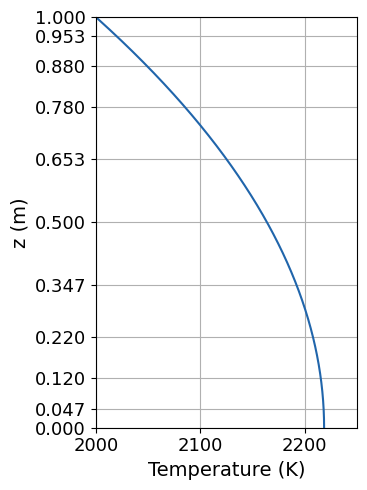

In [112]:
# Lettura dei parametri di riferimento dal file JSON
with open("../data/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)
FISSION_ENERGY = parameters["FISSION_ENERGY"]                       
FISSION_RATE = parameters["FISSION_RATE"]                   
LENGTH = parameters["LENGTH"]               
FUEL_THERMAL_CONDUCTIVITY = parameters["FUEL_THERMAL_CONDUCTIVITY"]
T_BC = parameters["T_BC"]  
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

OpenFOAM=pd.read_csv("../data/Temperature_along_z.csv")     

cmap = plt.get_cmap('RdBu')
color = cmap(0.9)

total_layers = list(set(coordinates_Px[:,2]))
effective_layers = sorted(list(set(coordinates_Px[:,2])))[::2]

fig, (ax1) = plt.subplots(1, figsize=(4,5))
#ax1.plot(OpenFOAM.iloc[:, -1], OpenFOAM.iloc[:, 0], label = 'OpenFOAM', color='#FF7F50', linewidth=1.5)
ax1.plot( T_BC + GAMMA_T * (1 - np.linspace(0,1 ,1001)**2) / 2, np.linspace(0,1,1001), label = '$T_\infty$', color=color, linewidth=1.5)
ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
ax1.set_yticks(effective_layers)
ax1.set_ylim([0, 1])
ax1.set_xlim([2000, 2250])
ax1.set_ylabel('z (m)',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.grid()
plt.tight_layout()
plt.savefig('Temperature profile.pdf', bbox_inches='tight') 

#ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)

error = ((np.abs((OpenFOAM.iloc[:, 0]-(T_BC + GAMMA_T * (1 - np.linspace(0, 1,1001)**2) / 2))))/OpenFOAM.iloc[:, 0])*100
print(np.max(error))

1.7999999999999999e+25


/Users/martina/Library/Python/3.9/lib/python/site-packages/matplotlib/tri/_triangulation.py:181: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)


La quota z al valore massimo della concentrazione è: 0.959596 m


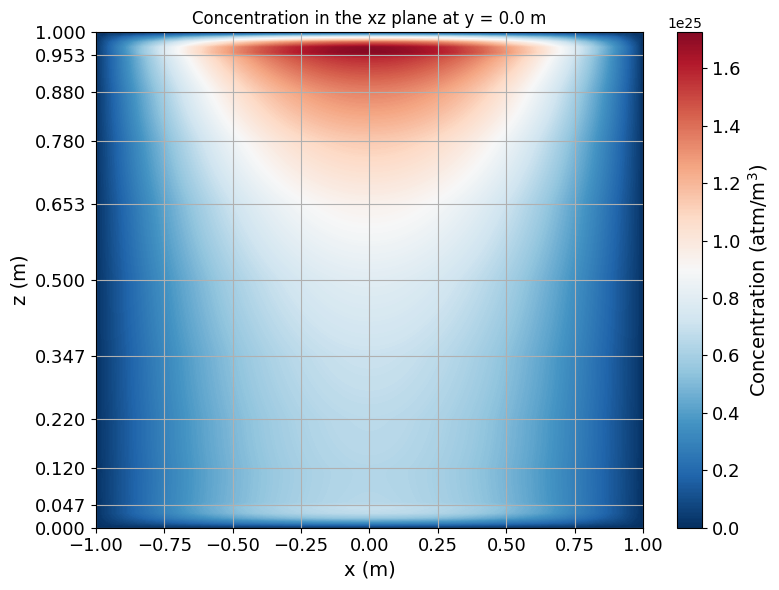

In [115]:
concentration_at_y = xz_y_0 @ sol_new_C[:, -1]
PP=99
x_coords_at_y = np.empty(((PP+1)*(PP+1)))
z_coords_at_y = np.empty(((PP+1)*(PP+1)))
for ii in range(PP+1):
    for jj in range(PP+1):
        index = (PP+1)*ii+jj
        x_coords_at_y[index] = 2*(ii/PP)-1
        z_coords_at_y[index] = jj/PP

# Converti in array NumPy
x_coords_at_y = np.array(x_coords_at_y)
z_coords_at_y = np.array(z_coords_at_y)

max_concentration = concentration_at_y.max()
tick_step = 0.2e25
max_tick = np.ceil(max_concentration / tick_step) * tick_step
print(max_tick)

total_layers = list(set(coordinates_Px[:,2]))
effective_layers = sorted(list(set(coordinates_Px[:,2])))[::2]

plt.figure(figsize=(8, 6))
contour = plt.tricontourf(x_coords_at_y, z_coords_at_y, concentration_at_y, 400, cmap='RdBu_r', vmin=0, vmax = max_tick)
cbar = plt.colorbar(contour, ticks=np.arange(0, max_tick, tick_step))    
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration (atm/m$^3$)', fontsize=14)

plt.title(f'Concentration in the xz plane at y = {0.00} m')
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlabel('x (m)',fontsize=14)
plt.ylabel('z (m)',fontsize=14)
plt.yticks(effective_layers)
plt.grid(True)
plt.tight_layout()
plt.savefig('FOM_xz.pdf', bbox_inches='tight')  

# Trova la coordinata z a cui corrisponde il valore massimo della concentrazione
max_index = np.argmax(concentration_at_y)  # Indice del valore massimo
z_max = z_coords_at_y[max_index]  # Coordinata z del massimo valore
print(f"La quota z al valore massimo della concentrazione è: {z_max:.6f} m")

/Users/martina/Library/Python/3.9/lib/python/site-packages/matplotlib/tri/_triangulation.py:181: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)


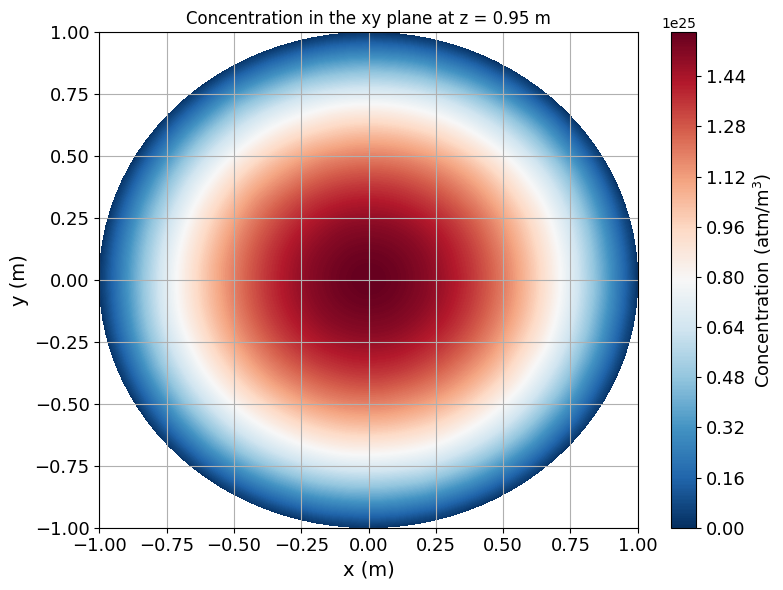

In [116]:
concentration_at_z = xy_z @ sol_new_C[:, -1]
PP=99
rmax = 1.0  # Raggio massimo
thetamax = 2 * np.pi  # Angolo massimo (2pi per un cerchio completo)

# Coordinate cartesiane x e y
x_coords_at_z = np.empty(((PP + 1) * (PP + 1)))
y_coords_at_z = np.empty(((PP + 1) * (PP + 1)))

# Genera le coordinate cartesiane
for ii in range(PP + 1):
    for jj in range(PP + 1):
        index = (PP + 1) * ii + jj
        r = (jj / PP) * rmax  # Distanza radiale
        theta = (ii / PP) * thetamax  # Angolo
        # Calcola le coordinate cartesiane (x, y)
        x_coords_at_z[index] = r * np.cos(theta)
        y_coords_at_z[index] = r * np.sin(theta)

# Converti in array NumPy
x_coords_at_z= np.array(x_coords_at_z)
y_coords_at_z = np.array(y_coords_at_z)

# Crea il grafico 2D della concentrazione nel piano xy a z = z_target
plt.figure(figsize=(8, 6))
contour = plt.tricontourf(x_coords_at_z, y_coords_at_z, concentration_at_z, 400, cmap='RdBu_r', vmin = 0)
cbar = plt.colorbar(contour)  # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration (atm/m$^3$)', fontsize=13)

plt.title(f'Concentration in the xy plane at z = {0.95} m')
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlabel('x (m)',fontsize=14)
plt.ylabel('y (m)',fontsize=14)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.grid(True)
plt.tight_layout()
plt.savefig('FOM_xy.pdf', bbox_inches='tight') 

### **2D plot (old approach)**

1.6e+25


/Users/martina/Library/Python/3.9/lib/python/site-packages/matplotlib/tri/_triangulation.py:181: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)


La quota z al valore massimo della concentrazione è: 0.953333 m


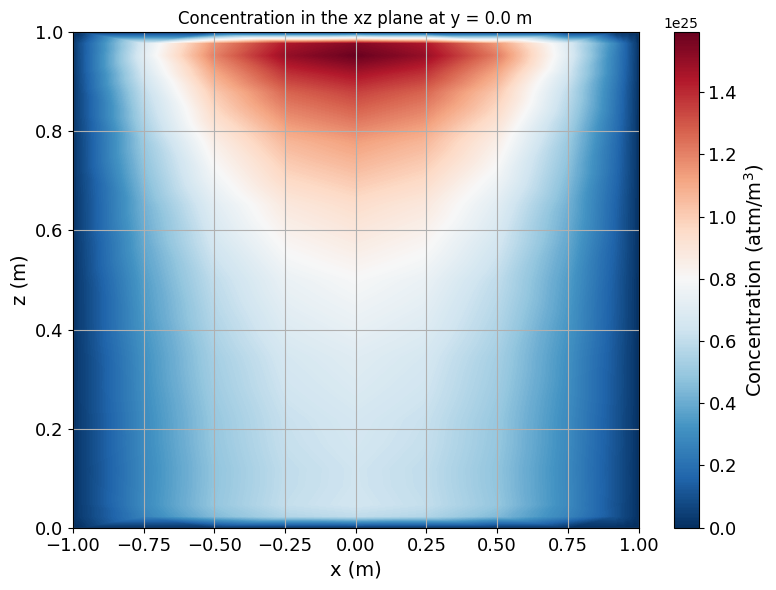

In [28]:
y_target = 0.0  
tolerance = 1E-6
mask_y = np.abs(coordinates_Px[:, 1] - y_target) < tolerance
x_coords_at_y = coordinates_Px[mask_y, 0]  
z_coords_at_y = coordinates_Px[mask_y, 2] 

concentration_at_y = sol_new_C[mask_y, -1]  # Concentrazione all'ultimo istante temporale
max_concentration = concentration_at_y.max()
tick_step = 0.2e25
max_tick = np.ceil(max_concentration / tick_step) * tick_step

print(max_tick)

# Crea il grafico 2D della concentrazione nel piano xz a y = y_target
plt.figure(figsize=(8, 6))
contour = plt.tricontourf(x_coords_at_y, z_coords_at_y, concentration_at_y, 400, cmap='RdBu_r', vmin=0, vmax = max_tick)
cbar = plt.colorbar(contour, ticks=np.arange(0, max_tick, tick_step))       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration (atm/m$^3$)', fontsize=14)

plt.title(f'Concentration in the xz plane at y = {y_target} m')
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlabel('x (m)',fontsize=14)
plt.ylabel('z (m)',fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('FOM_xz.pdf', bbox_inches='tight') 

# Trova l'indice del valore massimo della concentrazione
max_index = np.argmax(sol_new_C[:, -1])  # Indice del valore massimo
z_max = coordinates_Px[max_index, 2]  # Coordinata z del massimo valore
print(f"La quota z al valore massimo della concentrazione è: {z_max:.6f} m")

Max tick = 1.6e+25


/Users/martina/Library/Python/3.9/lib/python/site-packages/matplotlib/tri/_triangulation.py:181: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)


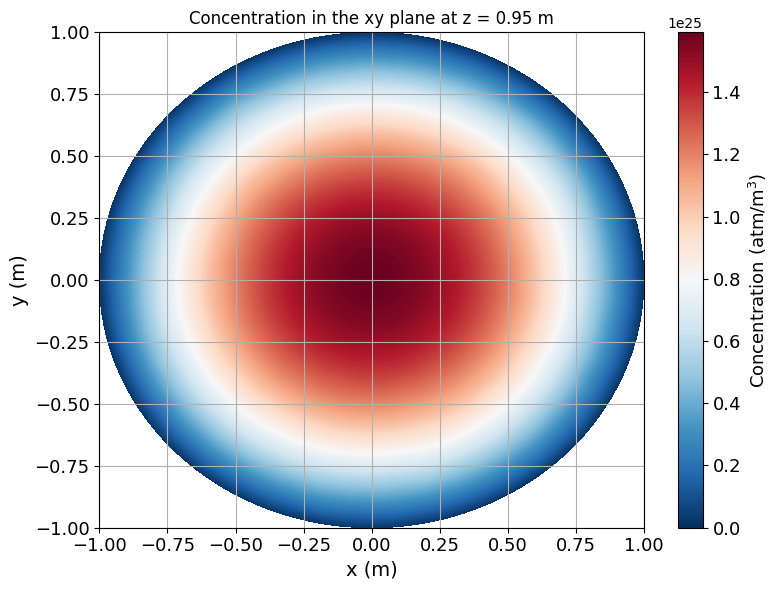

In [ ]:
# Definisci la quota z desiderata per la sezione orizzontale
z_target = 0.953333  # quota z per la sezione, puoi cambiarla come desideri

# Trova gli indici dei punti che si trovano a una distanza sufficientemente piccola dalla quota z_target
tolerance = 1.67E-2  # tolleranza per la selezione della quota z
mask_z = np.isclose(coordinates_Px[:, 2], z_target, atol=tolerance)

# Estrai le coordinate x e y per i punti alla quota z_target
x_coords_at_z = coordinates_Px[mask_z, 0]  # Coordinate x alla quota z
y_coords_at_z = coordinates_Px[mask_z, 1]  # Coordinate y alla quota z

# Estrai la concentrazione alla quota z_target
concentration_at_z = sol_new_C[mask_z, -1]  # Concentrazione all'ultimo istante temporale
max_concentration = concentration_at_y.max()
tick_step = 0.2e25
max_tick = np.ceil(max_concentration / tick_step) * tick_step
print(rf'Max tick = {max_tick}')

# Crea il grafico 2D della concentrazione nel piano xy a z = z_target
plt.figure(figsize=(8, 6))
contour = plt.tricontourf(x_coords_at_z, y_coords_at_z, concentration_at_z, 400, cmap='RdBu_r', vmin = 0, vmax = max_tick)
cbar = plt.colorbar(contour, ticks=np.arange(0, max_tick, tick_step))  # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration (atm/m$^3$)', fontsize=13)

plt.title(f'Concentration in the xy plane at z = {0.95} m')
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.ylim([-1, 1])
plt.xlabel('x (m)',fontsize=14)
plt.ylabel('y (m)',fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('FOM_xy.pdf', bbox_inches='tight') 

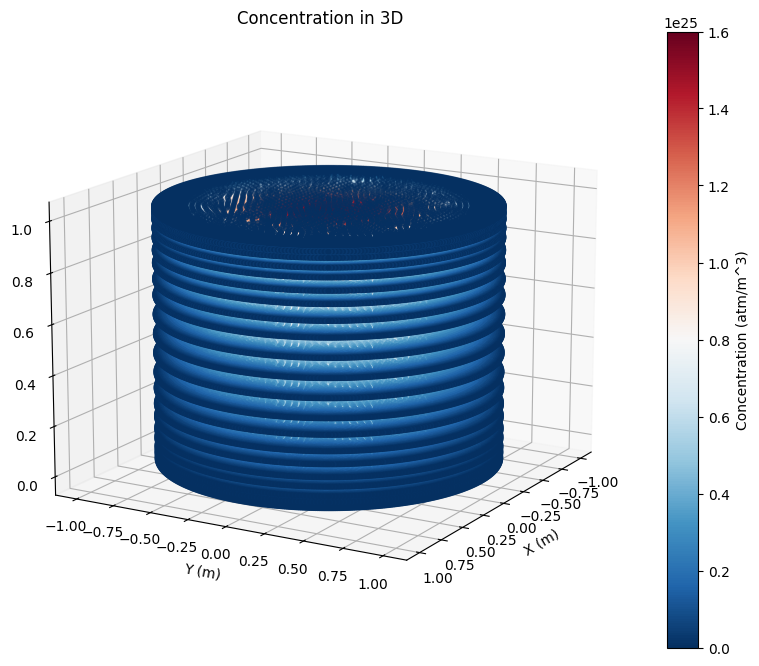

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
x_coords = coordinates_Px[:, 0]  # Coordinate x
y_coords = coordinates_Px[:, 1]  # Coordinate y
z_coords = coordinates_Px[:, 2]  # Coordinate z

concentration_at_final_time = sol_new_C[:, -1] 

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scat = ax.scatter(x_coords, y_coords, z_coords, c=concentration_at_final_time, cmap='RdBu_r', s=10, vmax = 1.6e25)

ax.view_init(elev=15, azim=30)

fig.colorbar(scat, label='Concentration (atm/m^3)')

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Concentration in 3D')
plt.show()